In [1]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
def generate_classification_counting_dataset(n, T, k, special_char='A', special_value=0, seed=None):
    """
    Génère un dataset pour une tâche de classification : prédire un entier entre 0 et T.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    letters = list(string.ascii_uppercase[:k])
    assert special_char in letters
    char_to_id = {c: i for i, c in enumerate(letters)}
    id_to_char = {i: c for c, i in char_to_id.items()}
    D = len(letters)
    embeddings = np.eye(D)

    X = []
    y = []

    for _ in range(n):
        seq = random.choices(letters, k=T)
        counts = {c: seq.count(c) for c in letters}
        y_seq = [special_value if c == special_char else counts[c] for c in seq]
        x_seq = [embeddings[char_to_id[c]] for c in seq]

        X.append(x_seq)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)

    return (
        torch.tensor(X, dtype=torch.float32),  # [n, T, D]
        torch.tensor(y, dtype=torch.long),     # [n, T] (classes entre 0 et T)
        char_to_id, id_to_char
    )


In [12]:
generate_dataset = generate_classification_counting_dataset

In [9]:
n = 10000
T = 50
D = 4

In [13]:
X, y, char_to_id, id_to_char = generate_dataset(n=n, T=T, k=D, special_char='A', special_value=7)


print(X.shape)  # torch.Size([1000, 10, 5])
print(y.shape)  # torch.Size([1000, 10])
print()
print("Exemple :", y[0])


torch.Size([10000, 50, 4])
torch.Size([10000, 50])

Exemple : tensor([ 7, 11,  7, 16, 16, 16, 11, 16, 12, 12, 16, 16, 11, 16, 11, 11,  7,  7,
        11, 12,  7, 16, 16, 16, 16,  7, 12, 11, 12, 12, 12,  7, 16,  7, 16, 16,
        11, 16, 12,  7,  7, 12, 12, 11, 12, 12, 11, 11,  7, 16])


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train[1], y_train[1]

(tensor([[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
 

In [16]:
class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(x.size(-1))
        self.attn_weights = attn_scores
        attn_weights = F.softmax(attn_scores, dim=-1)
        x = x + torch.matmul(attn_weights, V)
        x = self.norm(x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer_blocks = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, num_classes)  # classification

    def forward(self, x):
        x = self.embedding(x)
        for block in self.transformer_blocks:
            x = block(x)
        return self.fc(x)  # [B, T, C]


In [18]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # Attend [B, C, T] vs [B, T]

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)   # xb: [B, T, D], yb: [B, T]
            logits = model(xb)                      # [B, T, C]
            logits = logits.permute(0, 2, 1)        # -> [B, C, T] pour CrossEntropy
            loss = criterion(logits, yb)            # yb: [B, T]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Évaluation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)                      # [B, T, C]
                preds = torch.argmax(logits, dim=-1)    # [B, T]
                loss = criterion(logits.permute(0, 2, 1), yb)
                total_val_loss += loss.item()

                correct += (preds == yb).sum().item()
                total += yb.numel()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        accuracy = correct / total

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.4f}")


In [48]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

In [33]:
model = TransformerModel(input_dim=D, d_model=256, num_layers=2, num_classes=T + 1)

In [49]:
train_model(model, train_loader, test_loader, epochs=80, lr=0.001, device=device)

Epoch 1/80 | Train Loss: 3.0189 | Val Loss: 1.0216 | Val Acc: 0.5614
Epoch 2/80 | Train Loss: 0.8201 | Val Loss: 0.7360 | Val Acc: 0.8439
Epoch 3/80 | Train Loss: 0.6339 | Val Loss: 0.5570 | Val Acc: 0.9511
Epoch 4/80 | Train Loss: 0.4103 | Val Loss: 0.2800 | Val Acc: 0.9783
Epoch 5/80 | Train Loss: 0.1475 | Val Loss: 0.1303 | Val Acc: 0.9873
Epoch 6/80 | Train Loss: 0.0879 | Val Loss: 0.1202 | Val Acc: 0.9900
Epoch 7/80 | Train Loss: 0.0819 | Val Loss: 0.1209 | Val Acc: 0.9867
Epoch 8/80 | Train Loss: 0.0794 | Val Loss: 0.1208 | Val Acc: 0.9888
Epoch 9/80 | Train Loss: 0.0784 | Val Loss: 0.1171 | Val Acc: 0.9904
Epoch 10/80 | Train Loss: 0.0774 | Val Loss: 0.1266 | Val Acc: 0.9862
Epoch 11/80 | Train Loss: 0.0773 | Val Loss: 0.1161 | Val Acc: 0.9887
Epoch 12/80 | Train Loss: 0.0761 | Val Loss: 0.1168 | Val Acc: 0.9869
Epoch 13/80 | Train Loss: 0.0756 | Val Loss: 0.1171 | Val Acc: 0.9869


KeyboardInterrupt: 

In [51]:
def test_model_on_sequence(model, sequence, char_to_id, y_target, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Teste le modèle sur une séquence de lettres donnée.
    Affiche la séquence, les cibles attendues et les prédictions du modèle.
    Colore en vert les bons prédits, en rouge les erreurs.
    """
    import numpy as np
    D = len(char_to_id)
    embeddings = np.eye(D)

    x_seq = [embeddings[char_to_id[c]] for c in sequence]
    x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x_tensor).squeeze(0)     # [T, num_classes]
        preds = torch.argmax(logits, dim=-1).cpu().numpy()  # [T]

    print("📝 Input sequence  : ", end="")
    for i, c in enumerate(sequence):
        color = "\033[92m" if preds[i] == y_target[i] else "\033[91m"
        print(f"{color}{c:>3}\033[0m", end="")
    print()

    print("🎯 Expected counts : ", end="")
    for i, y in enumerate(y_target):
        color = "\033[92m" if preds[i] == y else "\033[91m"
        print(f"{color}{y:>3}\033[0m", end="")
    print()

    print("🔮 Model predicts  : ", end="")
    for i, y in enumerate(preds):
        color = "\033[92m" if y == y_target[i] else "\033[91m"
        print(f"{color}{y:>3}\033[0m", end="")
    print()



In [74]:
for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    sequence = ''.join([id_to_char[c] for c in X_test[idx].argmax(dim=-1).cpu().numpy()])
    sample_y = y_test[idx].cpu().numpy()
    print(f"Test {i + 1}:")
    test_model_on_sequence(model, sequence, char_to_id, sample_y)


Test 1:
📝 Input sequence  :   B  A  B  A  C  C  C  C  D  A  C  B  D  D  D  A  D  A  A  B  A  A  D  A  A  D  B  A  A  A  A  C  C  B  D  B  C  A  B  D  C  C  C  A  A  C  A  D  C  B
🎯 Expected counts :   9  7  9  7 13 13 13 13 10  7 13  9 10 10 10  7 10  7  7  9  7  7 10  7  7 10  9  7  7  7  7 13 13  9 10  9 13  7  9 10 13 13 13  7  7 13  7 10 13  9
🔮 Model predicts  :   9  7  9  7 13 13 13 13 10  7 13  9 10 10 10  7 10  7  7  9  7  7 10  7  7 10  9  7  7  7  7 13 13  9 10  9 13  7  9 10 13 13 13  7  7 13  7 10 13  9
Test 2:
📝 Input sequence  :   D  D  D  C  B  D  A  A  D  C  A  B  A  A  D  C  B  C  D  C  B  B  A  B  D  B  D  D  C  A  C  D  B  B  C  C  D  D  D  C  B  C  D  C  B  B  B  D  A  A
🎯 Expected counts :  16 16 16 12 13 16  7  7 16 12  7 13  7  7 16 12 13 12 16 12 13 13  7 13 16 13 16 16 12  7 12 16 13 13 12 12 16 16 16 12 13 12 16 12 13 13 13 16  7  7
🔮 Model predicts  :  16 16 16 12 13 16  7  7 16 12  7 13  7  7 16 12 13 12 16 12 13 13  7 13 16 13 16 16 12  7 12 16 13 13 12 12 

In [75]:
def compute_sequence_accuracy_class(preds, targets):
    pred_classes = torch.argmax(preds, dim=-1)  # [T]
    correct = (pred_classes == targets).sum().item()
    return correct / len(targets)

def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device='cuda' if torch.cuda.is_available() else 'cpu'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import torch.nn.functional as F
    import numpy as np

    D = len(char_to_id)
    embeddings = np.eye(D)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        x_seq = [embeddings[char_to_id[c]] for c in sequence]
        x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

        counts = {c: sequence.count(c) for c in char_to_id}
        y_target = torch.tensor([[
            special_value if c == special_char else counts[c]
            for c in sequence
        ]], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x_tensor).squeeze(0)  # [T, C]
        acc = compute_sequence_accuracy_class(logits, y_target.squeeze(0))

        k = min(20, len(sequence))
        attn0 = F.softmax(model.transformer_blocks[0].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k, :k]
        attn1 = F.softmax(model.transformer_blocks[1].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k, :k]

        sns.heatmap(attn0, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k],
                    square=True, cbar=True, ax=axs[i][0])
        axs[i][0].set_title(f"Layer 0 – Seq {i+1} – Acc: {acc:.2f}")
        axs[i][0].set_xlabel("Attended Tokens")
        axs[i][0].set_ylabel("Attending Tokens")
        axs[i][0].tick_params(axis='x', rotation=90)

        sns.heatmap(attn1, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k],
                    square=True, cbar=True, ax=axs[i][1])
        axs[i][1].set_title(f"Layer 1 – Seq {i+1} – Acc: {acc:.2f}")
        axs[i][1].set_xlabel("Attended Tokens")
        axs[i][1].set_ylabel("Attending Tokens")
        axs[i][1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
    return fig


In [77]:
def generate_random_sequences(n, T, k, seed=None):
    """
    Génère `n` séquences de taille `T` avec un alphabet de `k` lettres (A, B, ..., jusqu’à k).
    """
    if seed is not None:
        random.seed(seed)

    alphabet = list(string.ascii_uppercase[:k])
    sequences = [random.choices(alphabet, k=T) for _ in range(n)]
    return sequences

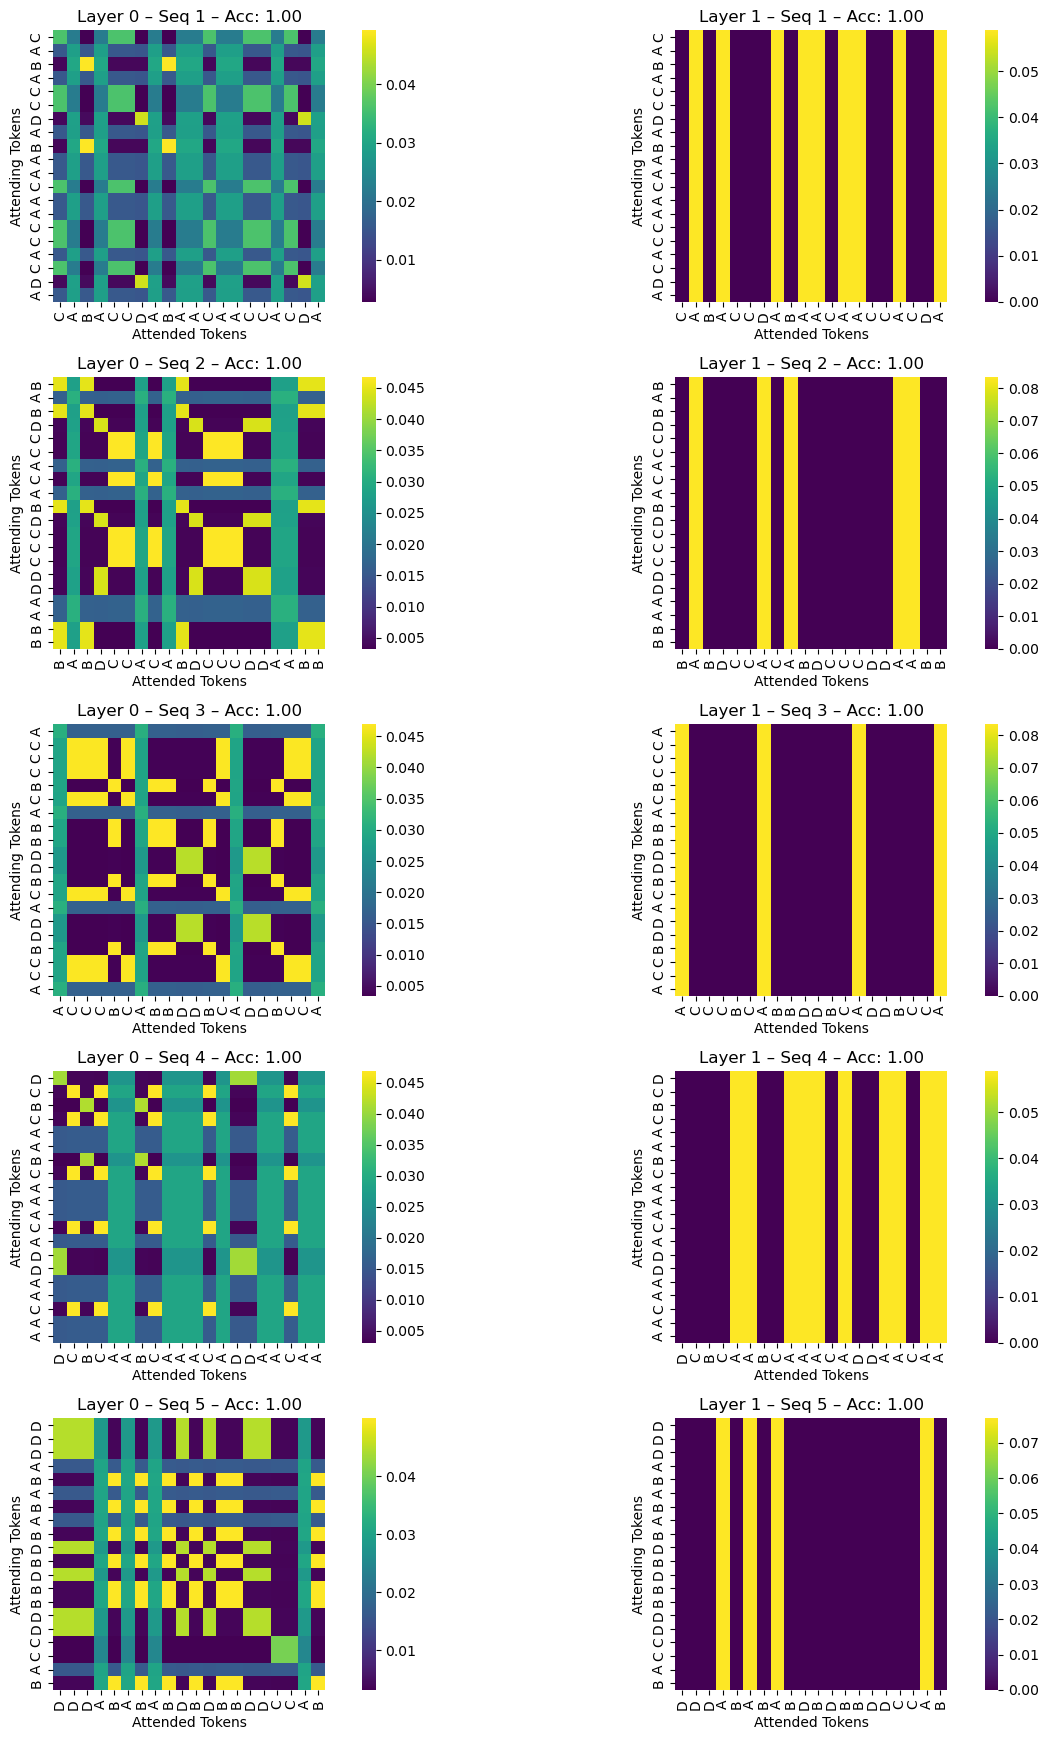

In [81]:
test_sequences = generate_random_sequences(n=5, T=T, k=D, seed=42)

fig = plot_attention_matrices_with_accuracy(
    model=model,
    sequences=test_sequences,
    char_to_id=char_to_id,
    special_char='A',
    special_value=7,
    device=device
)

In [82]:
fig.savefig("images/attention_matrix_classification task.png", dpi=300)

In [591]:
def extract_all_token_to_token_attention(model, data_loader, id_to_char, token_list, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Retourne un dictionnaire contenant pour chaque token (ex: 'A') les valeurs d'attention entre
    toutes les paires de positions i, j où les deux tokens sont égaux à ce token.
    """
    model.eval()
    model.to(device)

    char_to_id = {v: k for k, v in id_to_char.items()}
    target_indices = {token: char_to_id[token] for token in token_list}
    token_attn_values = {token: [] for token in token_list}

    with torch.no_grad():
        for xb, _ in data_loader:
            xb = xb.to(device)
            _ = model(xb)  # met à jour model.transformer_blocks[0].attn_weights

            attn = model.transformer_blocks[1].attn_weights  # [B, T, T]

            attn = F.softmax(attn, dim=-1)
            attn = attn.detach().cpu().numpy()
            
            tokens = xb.argmax(dim=-1)  # [B, T] → indices des tokens

            for b in range(xb.size(0)):
                for token, idx in target_indices.items():
                    for i in range(xb.size(1)):
                        if tokens[b, i].item() == idx:
                            for j in range(xb.size(1)):
                                if tokens[b, j].item() == idx:
                                    attn_ij = attn[b, i, j].item()
                                    token_attn_values[token].append(attn_ij)

    return token_attn_values


In [592]:
tokens_of_interest = ['A', 'B', 'C', 'D']
Attn_token_to_token = extract_all_token_to_token_attention(model, test_loader, id_to_char, tokens_of_interest, device=device)


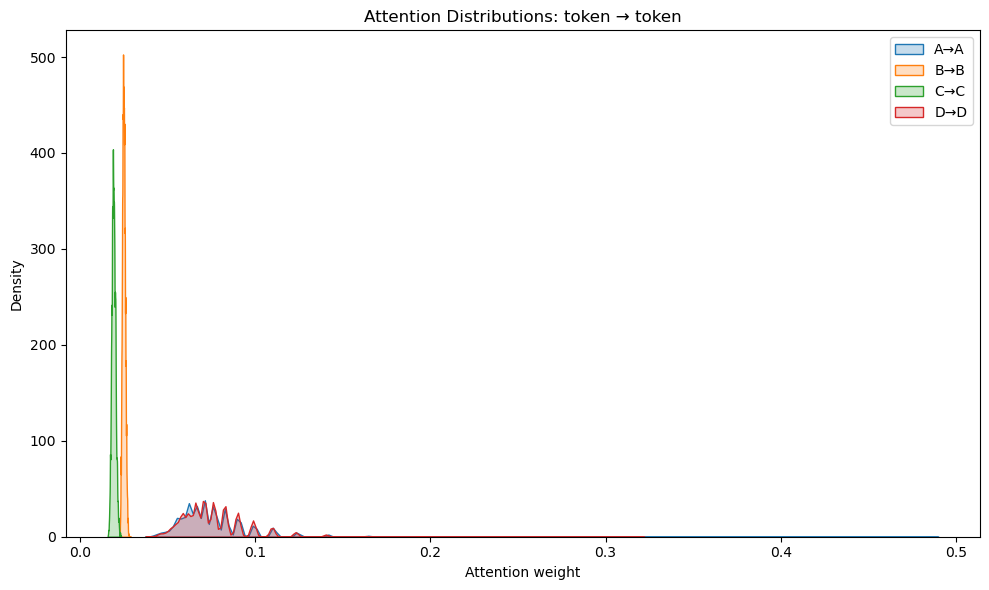

In [590]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for token in tokens_of_interest:
    sns.kdeplot(Attn_token_to_token[token], label=f"{token}→{token}", fill=True)

plt.title("Attention Distributions: token → token")
plt.xlabel("Attention weight")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


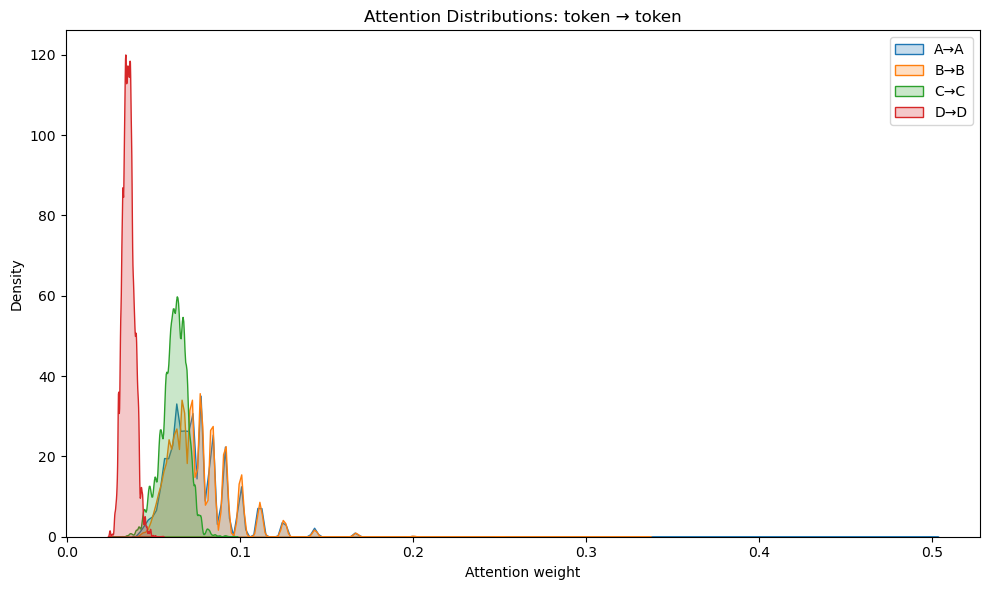

In [593]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for token in tokens_of_interest:
    sns.kdeplot(Attn_token_to_token[token], label=f"{token}→{token}", fill=True)

plt.title("Attention Distributions: token → token")
plt.xlabel("Attention weight")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()